In [1]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 5.0)

# Part B: Condensation

Now, we will track a given shape (template) as it moves in a sequence of
frames. Our shape/appearance model is trivial: just a template, given.
We will only explore simple motion models. Such models may
contain a variable that switches between cars and pedestrians, or traffic
in different directions, or accelerating etc.
 
Note: depending on the motion model, the state w will have different
numbers of dimensions (not just 2, though that's the default). 

Most of this algorithm should be copied from Part A. An important
difference is that now we'll actually compute the likelihood using the
(provided) computeLikelihood() function.


TO DOs:

- Complete the To Dos from part A.
- Change the state to have 2 more degrees of freedom: velX and velY.
  (This will require you to change how state-predictions are made, and 
  how they are converted to measurement-space)
- Try varying the number of particles: 2000, 500, 100,... What can you observe?
- Try varying the noise level. What can you observe?
  


In [2]:
#Likelihood function is simple patch similarity
#Note that below, we add a few 'corrections', such as
#manually masking out the sky for better results

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image, template, methods[0])
    #we manually eliminate incorrect matches in the sky
    #since we know that there cannot be any cars in those areas
    likelihood[:int(likelihood.shape[0] / 2), :] = 0.0
    
    #we can then pad to make this the size of the input image (for easier indexing)
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((pad_first, pad_first), (pad_second, pad_second))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    
    return likelihood

We are matching this template with shape:  (27, 18, 3)


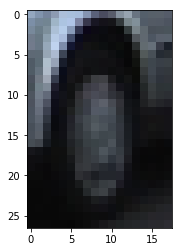

Processing Frame 0


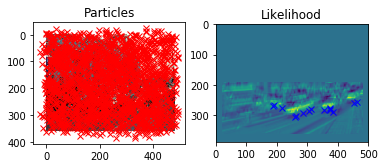

Processing Frame 1


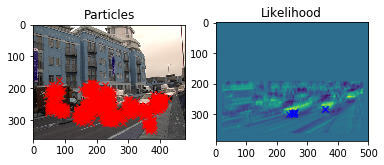

Processing Frame 2


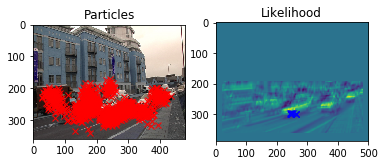

Processing Frame 3


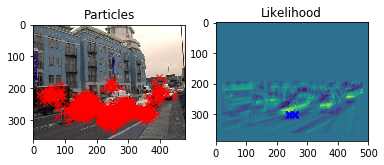

Processing Frame 4


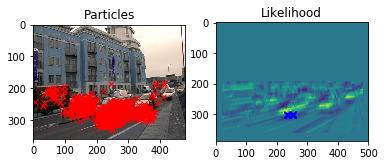

Processing Frame 5


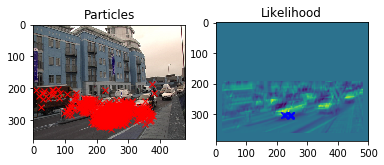

Processing Frame 6


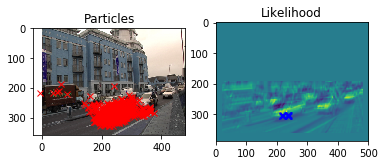

Processing Frame 7


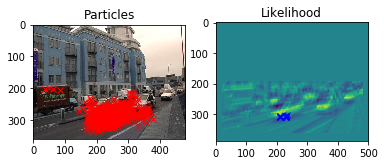

Processing Frame 8


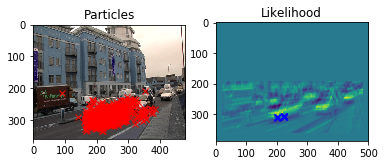

Processing Frame 9


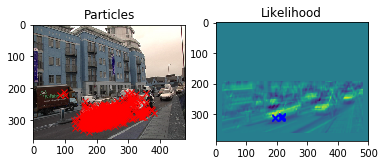

Processing Frame 10


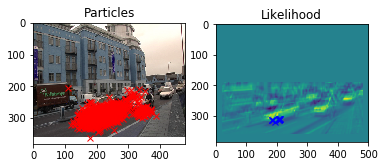

Processing Frame 11


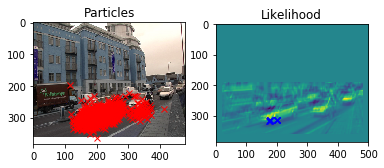

Processing Frame 12


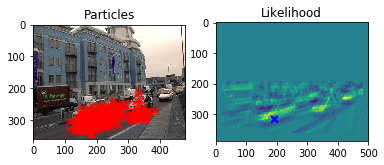

Processing Frame 13


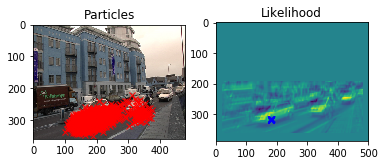

Processing Frame 14


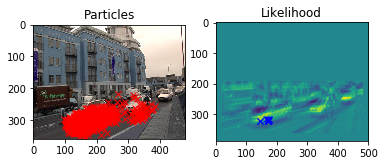

Processing Frame 15


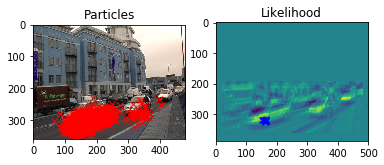

Processing Frame 16


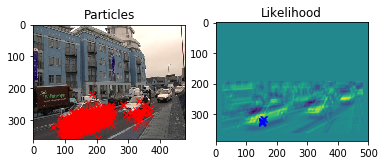

Processing Frame 17


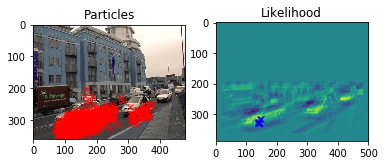

Processing Frame 18


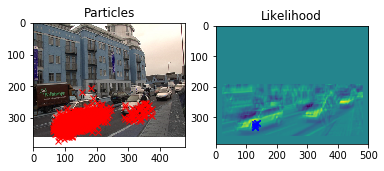

Processing Frame 19


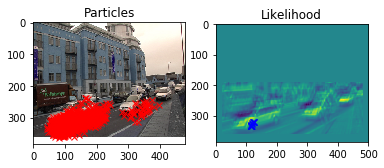

Processing Frame 20


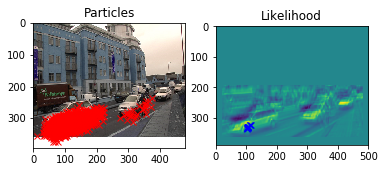

Processing Frame 21


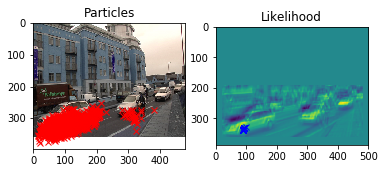

In [3]:
# Load template and starting position ('pos'), which come from frame 871.
template = sp.io.loadmat('data/Template.mat')['pixelsTemplate']

#let's show the template
print('We are matching this template with shape: ', template.shape)
plt.imshow(template)
plt.show()

# Load images
images = []
iFrame = 0
for frameNum in range(872, 894 + 1):
    imageName = 'data/HillsRdSkipFrames_%07d.png' % frameNum
    images.append(cv.imread(imageName))
    plt.show()
    iFrame += 1

imgHeight, imgWidth, colors = images[0].shape
numParticles = 2000;
weight_of_samples = np.ones((numParticles,1))

# TO DO: normalize the weights (may be trivial this time) [done]
weight_of_samples = weight_of_samples/np.sum(weight_of_samples) #replace this 

# Initialize which samples from "last time" we want to propagate: all of
# them!:
samples_to_propagate = range(0, numParticles)


# ============================
# The first two dimensions represent position while the last two now represent velocity:
numDims_w = 4; 
# Here we randomly initialize some particles throughout the space of w:
particles_old = np.random.rand(numParticles, numDims_w)
particles_old[:,0] = particles_old[:,0] * imgHeight
particles_old[:,1] = particles_old[:,1] * imgWidth
particles_old[:,2] = 10.0 * np.random.randn(numParticles)
particles_old[:,3] = 10.0 * np.random.randn(numParticles)
# ============================

for iTime in range(22):
    print('Processing Frame', iTime)
    # TO DO: compute the cumulative sume of the weights. [done]
    cum_hist_of_weights = np.cumsum(weight_of_samples) # replace this 


    # ==============================================================
    # Resample the old distribution at time t-1, and select samples, favoring
    # those that had a higher posterior probability.
    # ==============================================================
    samples_to_propagate = np.zeros(numParticles, dtype=np.int32)
    
    # Pick random thresholds in the cumulative probability's range [0,1]:
    some_threshes = np.random.rand(numParticles)


    # For each random threshold, find which sample in the ordered set is
    # the first one to push the cumulative probability above that
    # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
    # between the 17th and 18th samples in the old distribution, and the
    # threshold is 0.234, then we'll want to propagate the 18th sample's w
    # (i.e. particle #18).
    
    for sampNum in range(numParticles): 
        thresh = some_threshes[sampNum]
        for index in range (numParticles):
            if cum_hist_of_weights[index] > thresh:
                break
        samples_to_propagate[sampNum] = index
    
    # Note: it's ok if some of the old particles get picked repeatedly, while
    # others don't get picked at all.

    # Predict where the particles from the old distribution of 
    # state-space will go in the next time-step. This means we have to apply 
    # the motion model to each old sample.

    particles_new = np.zeros(particles_old.shape)
    for particleNum in range(numParticles):      
        # TO DO: Incorporate some noise, e.g. Gaussian noise with std 10,
        # into the current location (particles_old), to give a Brownian
        # motion model with changing velocity. Remember: the first two 
        # dimensions of w represent position while the last two represent velocity 
        # and you should add noise to both. 
        
        noisePosition = 10 #replace this
        noiseVelocity = 2 #replace this
        
        particles_new[particleNum, 2:] = particles_old[samples_to_propagate[particleNum], 2:] + np.random.normal(0,noiseVelocity,2) #replace this
        
        particles_new[particleNum, :2] = particles_old[samples_to_propagate[particleNum], :2] + particles_old[samples_to_propagate[particleNum], 2:] + np.random.normal(0,noisePosition,2) #replace this
        particles_new[particleNum, :2] = np.round(particles_new[particleNum, :2]) # Round the particles_new to simplify Likelihood evaluation.
    
    # You can experiment with the motion model above to have
    # different degrees of freedom, and optionally completely different
    # motion models.
    
    #calculate likelihood function
    likelihood = computeLikelihood(images[iTime], template)
    
    #plot particles
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(images[iTime])
    axarr[0].set_title('Particles')
    # now draw the particles onto the image
    axarr[0].plot(particles_new[:,1], particles_new[:,0], 'rx')
    
    
    #plot the likelihood
    axarr[1].imshow(likelihood)
    axarr[1].set_title('Likelihood')

    
    # From here we incorporate the data for the new state (time t):
    # The new particles accompanying predicted locations in state-space
    # for time t, are missing their weights: how well does each particle
    # explain the observations x_t?
    for particleNum in range(numParticles):

        # Convert the particle from state-space w to measurement-space x:
        # Note: that step is trivial here since both are in 2D space of image
        # coordinates

        # Within the loop, we evaluate the likelihood of each particle:
        particle = particles_new[particleNum, :]
        # Check that the predicted location is a place we can really evaluate
        # the likelihood.
        inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
        if inFrame:
            minX = particle[1]
            minY = particle[0]

            weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]
        else:
            weight_of_samples[particleNum] = 0.0

    # TO DO: normalize the weights [done]
    weight_of_samples = weight_of_samples/np.sum(weight_of_samples) #replace this

    #Plot the 15 best scoring particles
    indices = np.argsort(weight_of_samples, axis = 0)
    bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
    
    plt.plot(bestScoringParticles[:,1]+template.shape[1]/2, bestScoringParticles[:,0]+template.shape[0]/2, 'bx')
    plt.show()
    
    # Now we're done updating the state for time t. 
    # For Condensation, just clean up and prepare for the next round of 
    # predictions and measurements:
    particles_old = particles_new


**The diagrams above show the condensation algorithm**


**The diagrams on the right show likelihood function which assigns weights and the digram on the left shows how each particle moves from one iteration to the next. The particles always move towards the area of heighest weights. </br> Depending on the method of assigning weight (e.g TM_CCOEFF), the algorithm performs differently**